In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('style/advocate.mplstyle')
%matplotlib inline
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


# Block group income analysis

Compare uncovered damage vs. income level/poverty level (we would use 2000 Census data – “what did it look like before you got the grant”, a pre-flood view) GeoIDs for the blocks are all 2000.
Assigned: Sophie
Needs:
This nonprofit has already matched tracts to neighborhoods (https://www.datacenterresearch.org/); Jeff will pop data into the drive
What ACS time period should we use?
Timing: Days (let’s check in on our Monday meeting 9/19)
Status: In progress


### Load Flooding data
- rh_block_groups_nola_flood_GT3
- These files have racial/ethnic demographic information and the Road Home data. Note that as with the neighborhoods file, the demographic information is the aggregate of all the blocks in the block group but the RH data only aggregates blocks that had more than 3 feet of flooding.

In [2]:
df_flood = pd.read_csv('processed data/rh_block_groups_nola_flood_GT3.csv', index_col=0)

In [3]:
len(df_flood)

485

In [4]:
df_flood.columns

Index(['BKGPIDFP00', 'geometry', 'GEOID', 'compensation_sum',
       'additional_compensation_sum', 'elevation_sum', 'mitigation_sum',
       'all_grants_sum', 'all_grants_count', 'value_sum', 'damage_sum',
       'insurance_sum', 'Total', 'White', 'Black', 'Hispanic', 'Indigenous',
       'Asian', 'NHOPI', 'Other', 'Multiracial', 'households_2000_total',
       'households_2000_owner_occupied',
       'households_2000_owner_occupied_black', 'damage_mean',
       'grant_insurance_sum', 'grant_insurance_mean', 'uncovered_sum',
       'uncovered_mean', 'uncovered_percent', 'white_percent',
       'rh_household_pct', 'households_2000_owner_occupied_pct',
       'households_2000_owner_occupied_black_pct'],
      dtype='object')

### Load Census block group data from IPUMS
Compare uncovered damage vs. income level/poverty level (we would use 2000 Census data – “what did it look like before you got the grant”, a pre-flood view) GeoIDs for the blocks are all 2000.



In [5]:
df_census = pd.read_csv('raw data/nhgis0015_csv/nhgis0015_ds152_2000_blck_grp.csv')

In [6]:
len(df_census) # should be 3509

3509

### Limit to just census block groups in Orleans parish

In [7]:
df_census.columns

Index(['GISJOIN', 'YEAR', 'STATE', 'STATEA', 'COUNTY', 'COUNTYA', 'CTY_SUBA',
       'PLACEA', 'TRACTA', 'BLCK_GRPA', 'AIANHHA', 'URBRURALA', 'NAME',
       'HAK001', 'HAQ001', 'HAQ002', 'HAR001', 'HAR002', 'HAR003', 'HAR004',
       'HAR005', 'HAR006', 'HAR007', 'HAR008', 'HAR009', 'HAR010', 'HAR011',
       'HAR012', 'HAR013', 'HAR014', 'HA2001', 'HF5001', 'HF5002', 'HF5003',
       'HF5004', 'HF5005', 'HF5006', 'HF5007', 'HF5008', 'HF5009', 'HF5010',
       'HF5011', 'HF5012', 'HF5013', 'HF5014', 'HF5015', 'HF5016', 'HF6001',
       'HF7001', 'HHE001', 'HHE002', 'HHS001', 'HHS002'],
      dtype='object')

In [8]:
df_census.COUNTY.value_counts()[:10]

Orleans             485
Jefferson           357
East Baton Rouge    306
Caddo               210
Calcasieu           133
Lafayette           131
Ouachita            126
St Tammany          101
Rapides              96
Terrebonne           80
Name: COUNTY, dtype: int64

In [9]:
df_orleans = df_census[df_census.COUNTY == "Orleans"]

In [10]:
len(df_orleans)

485

In [11]:
df_orleans.BLCK_GRPA.value_counts()

1    176
2    158
3     95
4     42
5      9
6      4
7      1
Name: BLCK_GRPA, dtype: int64

In [12]:
df_orleans.head()

,GISJOIN,YEAR,STATE,STATEA,COUNTY,COUNTYA,CTY_SUBA,PLACEA,TRACTA,BLCK_GRPA,AIANHHA,URBRURALA,NAME,HAK001,HAQ001,HAQ002,HAR001,HAR002,HAR003,HAR004,HAR005,HAR006,HAR007,HAR008,HAR009,HAR010,HAR011,HAR012,HAR013,HAR014,HA2001,HF5001,HF5002,HF5003,HF5004,HF5005,HF5006,HF5007,HF5008,HF5009,HF5010,HF5011,HF5012,HF5013,HF5014,HF5015,HF5016,HF6001,HF7001,HHE001,HHE002,HHS001,HHS002
1931,G22007100001001,2000,Louisiana,22,Orleans,71,NaN,NaN,100,1,NaN,NaN,Block Group 1,973,936,37,531,353,13,23,0,0,16,28,0,0,9,0,0,0,351,43,17,18,13,18,42,50,3,36,9,27,36,16,8,9,6,37269,19557400,294,679,58,293
1932,G22007100001002,2000,Louisiana,22,Orleans,71,NaN,NaN,100,2,NaN,NaN,Block Group 2,868,817,51,551,245,0,0,0,0,21,51,0,0,0,0,0,0,376,21,54,41,23,28,19,25,22,42,42,24,3,13,0,7,12,35278,18725700,86,782,43,333
1933,G22007100001003,2000,Louisiana,22,Orleans,71,NaN,NaN,100,3,NaN,NaN,Block Group 3,568,491,77,442,45,4,0,0,0,0,11,0,0,0,0,66,0,353,28,15,16,35,14,3,35,38,3,43,46,43,13,15,0,6,44185,18370000,37,531,28,325
1934,G22007100002001,2000,Louisiana,22,Orleans,71,NaN,NaN,200,1,NaN,NaN,Block Group 1,753,753,0,94,659,0,0,0,0,0,0,0,0,0,0,0,0,324,80,29,34,53,37,18,9,6,11,0,22,17,0,0,8,0,21979,9070200,372,381,130,194
1935,G22007100002002,2000,Louisiana,22,Orleans,71,NaN,NaN,200,2,NaN,NaN,Block Group 2,710,710,0,144,530,0,0,0,13,23,0,0,0,0,0,0,0,201,80,18,28,21,25,0,4,5,0,8,8,4,0,0,0,0,15298,3837400,331,379,76,125


### Convert GISJOIN to GEOID
- Remove G
- Remove zero in third/4th digit  
- Remove 6th/8th digit (0)   
- 12 digits is block group code

In [13]:
len('G22007100001001')

15

In [14]:
len("220710033042")

12

In [15]:
df_orleans.GISJOIN 

1931    G22007100001001
1932    G22007100001002
1933    G22007100001003
1934    G22007100002001
1935    G22007100002002
             ...       
2411    G22007100133012
2412    G22007100133013
2413    G22007100133014
2414    G22007100133021
2415    G22007100133022
Name: GISJOIN, Length: 485, dtype: object

In [16]:
df_orleans["GEOID"] = df_orleans.GISJOIN.str[1:3] + df_orleans.GISJOIN.str[4:7] + df_orleans.GISJOIN.str[8:] 

<ipython-input-16-f45f25be0a73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orleans["GEOID"] = df_orleans.GISJOIN.str[1:3] + df_orleans.GISJOIN.str[4:7] + df_orleans.GISJOIN.str[8:]


### Join two datasets

In [17]:
len(df_orleans.GEOID.unique()) ## Good, 485 unique rows

485

In [18]:
df_flood['GEOID'] = df_flood.GEOID.astype("str") # convert to string

In [45]:
df_merged = df_flood.merge(df_orleans, left_on="GEOID", right_on="GEOID")

In [46]:
len(df_merged)

485

### Rename subset of columns -- we can save the rest for later.

In [47]:
df_merged.rename(columns=
{"HAK001": "total_pop",
"HA2001":"total_households",
"HAQ001": "not_hispanic",
"HAQ002": "hispanic",
"HAR001":"not_hispanic_white",
"HAR002":"not_hispanic_black",
"HAR003":"not_hispanic_native",
"HAR004":"not_hispanic_asian",
"HAR005":"not_hispanic_pacific_islander",
"HAR006":"not_hispanic_other",
"HAR007":"not_hispanic_two_or_more",
"HAR008":"hispanic_white",
"HAR009":"hispanic_black",
"HAR010":"hispanic_native",
"HAR011":"hispanic_asian",
"HAR012":"hispanic_pacific_islander",
"HAR013":"hispanic_other",
"HAR014":"hispanic_two_or_more",
"HF5001":"hh_lt_10000",
"HF5002":"hh_10000_1499",
"HF5003":"hh_15000_19999",
"HF5004":"hh_20000_24,999",
"HF5005":"hh_25000_29999",
"HF5006":"hh_30000_34999",
"HF5007":"hh_35000_39999",
"HF5008":"hh_40000_44999",
"HF5009":"hh_45000_49999",
"HF5010":"hh_50000_59999",
"HF5011":"hh_60000_74999",
"HF5012":"hh_75000_99999",
"HF5013":"hh_100000_124999",
"HF5014":"hh_125000_149999",
"HF5015":"hh_150000_199999",
"HF5016":"hh_gte_200000",
"HF6001":"hh_median_income",
"HHE001":"persons_below_poverty_level",
"HHE002":"persons_at_or_below_poverty_level",
"HHS001":"hh_below_poverty_level",
"HHS002":"hh_at_or_below_poverty_level"}, inplace=True)

In [25]:
df_merged.columns

Index(['BKGPIDFP00', 'geometry', 'GEOID', 'compensation_sum',
       'additional_compensation_sum', 'elevation_sum', 'mitigation_sum',
       'all_grants_sum', 'all_grants_count', 'value_sum', 'damage_sum',
       'insurance_sum', 'Total', 'White', 'Black', 'Hispanic', 'Indigenous',
       'Asian', 'NHOPI', 'Other', 'Multiracial', 'households_2000_total',
       'households_2000_owner_occupied',
       'households_2000_owner_occupied_black', 'damage_mean',
       'grant_insurance_sum', 'grant_insurance_mean', 'uncovered_sum',
       'uncovered_mean', 'uncovered_percent', 'white_percent',
       'rh_household_pct', 'households_2000_owner_occupied_pct',
       'households_2000_owner_occupied_black_pct', 'GISJOIN', 'YEAR', 'STATE',
       'STATEA', 'COUNTY', 'COUNTYA', 'CTY_SUBA', 'PLACEA', 'TRACTA',
       'BLCK_GRPA', 'AIANHHA', 'URBRURALA', 'NAME', 'total_pop',
       'not_hisp_latino', 'hisp_latino', 'not_hispanic_white',
       'not_hispanic_black', 'not_hispanic_native', 'not_hispan

### Compare with Jeff's dataset (non-sampled Census)

In [27]:
df_merged[['Black','not_hispanic_black',"Total","total_pop" ]].head(20)

,Black,not_hispanic_black,Total,total_pop
0,1119,1229,1452,1488
1,40,0,395,377
2,754,758,785,821
3,0,0,791,790
4,609,630,814,785
5,531,519,572,559
6,7,16,612,619
7,274,222,650,649
8,357,367,742,752
9,773,862,1354,1447


## Data check: Jeff's census data, SF3 table, SF1B table from IPUMS

In [28]:
df_sf1b = pd.read_csv('raw data/nhgis0013_csv/nhgis0013_ds147_2000_blck_grp.csv')

In [29]:
df_sf1b["GEOID"] = df_sf1b.GISJOIN.str[1:3] + df_sf1b.GISJOIN.str[4:7] + df_orleans.GISJOIN.str[8:] 

In [30]:
#super joined table for checking
df_superset = df_merged.merge(df_sf1b, left_on="GEOID", right_on="GEOID")

In [31]:
len(df_superset)

485

In [32]:
# Comparison between Jeff's data, table 3, data including hispanic, table 2 non hispanic black, Total from Jeff, total from table 3, total from table 2

In [35]:
df_superset[['Black','not_hispanic_black',"FYF002", "Total","total_pop","FXS001" ]].to_csv('processed data/data_comparison_test.csv')

## Calculate poverty statistics

In [49]:
## NOTE: DO NOT USE "TOTAL_POP_POVERTY_STATUS" or HHD001. USE INCOME_LT_POVERTY_LVL or HHE001: Income in 1999 below poverty level
df_merged['percent_poverty_status'] = df_merged['hh_below_poverty_level']/df_merged['total_households']

In [50]:
df_merged.percent_poverty_status.describe()

count   482.00
mean      0.27
std       0.17
min       0.00
25%       0.13
50%       0.25
75%       0.38
max       0.84
Name: percent_poverty_status, dtype: float64

Overall uncovered percent

In [51]:
df_merged.uncovered_percent.mean()

0.2514802516238942

In [52]:
df_merged.uncovered_percent.median()

0.2485591586781901

In [53]:
df_merged.uncovered_percent.std()

0.09052210548286699

<AxesSubplot:>

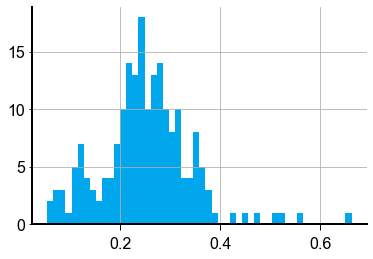

In [54]:
df_merged.uncovered_percent.hist(bins=50)

For those block groups where there was a poverty rate of 25% or LESS, the average uncovered_percent was X.

In [56]:
df_25 = df_merged[df_merged.percent_poverty_status <= .25]

In [57]:
df_25.uncovered_percent.mean()

0.2317141493358759

For those block groups where there was a poverty rate of 50% or more, the average uncovered_percent was 31%.

In [58]:
df_50 = df_merged[df_merged.percent_poverty_status >= .50]

In [59]:
df_50.uncovered_percent.mean()

0.31450763508666146

In [60]:
df_50.uncovered_percent.median()

0.2889270793912417

For those block groups where there was a poverty rate of 60% or more, the average uncovered_percent was 45%.

In [61]:
df_60 = df_merged[df_merged.percent_poverty_status >= .60]

In [62]:
df_60.uncovered_percent.mean()

0.45199638874428766

In [63]:
df_60.uncovered_percent.median()

0.45199638874428766

## Income analysis

In [68]:
df_merged.hh_median_income.mean()

30094.663917525773

In [70]:
df_merged.hh_median_income.median()

25273.0

In [72]:
df_merged.hh_median_income.describe()

count       485.00
mean     30,094.66
std      20,269.01
min           0.00
25%      17,353.00
50%      25,273.00
75%      36,964.00
max     200,001.00
Name: hh_median_income, dtype: float64

In [76]:
# SAME AS DATA CENTER
df_merged.hh_lt_10000.sum() / df_merged.total_households.sum()

0.21032038860722532

In [82]:
df_merged[df_merged['hh_median_income'] <= 10000].uncovered_percent.mean()

0.3449603025262253

In [84]:
df_merged[(df_merged['hh_median_income'] > 10000)&(df_merged['hh_median_income'] <= 25000)].uncovered_percent.mean()

0.2770508112423456

In [85]:
df_merged[(df_merged['hh_median_income'] > 25000)&(df_merged['hh_median_income'] <= 50000)].uncovered_percent.mean()

0.23581074568840377

In [86]:
df_merged[(df_merged['hh_median_income'] > 50000)&(df_merged['hh_median_income'] <= 100000)].uncovered_percent.mean()

0.21498087303146957

In [88]:
df_merged[(df_merged['hh_median_income'] > 100000)].uncovered_percent.mean()

0.0543079082768738